In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os
import shutil
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, save_img
from tqdm import tqdm

# Path asal dataset
original_path = "/content/drive/MyDrive/KS"

# Path dataset baru seimbang
balanced_path = "/content/drive/MyDrive/KS_seimbang3"
os.makedirs(balanced_path, exist_ok=True)

# Target jumlah gambar per kelas
TARGET = 2000

# Augmentasi
datagen = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

def balance_class(cls_name):
    src = os.path.join(original_path, cls_name)
    dst = os.path.join(balanced_path, cls_name)
    os.makedirs(dst, exist_ok=True)

    all_images = os.listdir(src)
    random.shuffle(all_images)
    n = len(all_images)

    # Jika terlalu banyak gambar (undersampling)
    if n >= TARGET:
        selected = all_images[:TARGET]
        for img in selected:
            shutil.copy(os.path.join(src, img), os.path.join(dst, img))

    # Jika gambar terlalu sedikit (oversampling)
    else:
        # Copy semua gambar asli dulu
        for img in all_images:
            shutil.copy(os.path.join(src, img), os.path.join(dst, img))

        # Hitung jumlah gambar yang perlu diaugmentasi
        tambahan = TARGET - n
        gen = datagen.flow_from_directory(
            original_path,
            classes=[cls_name],
            target_size=(224, 224),
            batch_size=1,
            class_mode=None,
            save_to_dir=dst,
            save_prefix='aug_',
            save_format='jpeg'
        )

        # Jalankan augmentasi hingga cukup
        pbar = tqdm(total=tambahan, desc=f"Augmenting {cls_name}")
        for _ in range(tambahan):
            next(gen)
            pbar.update(1)
        pbar.close()

# Jalankan untuk semua kelas
for cls in ['Organik', 'Anorganik', 'B3']:
    balance_class(cls)


Found 945 images belonging to 1 classes.


Augmenting B3: 100%|██████████| 1055/1055 [00:36<00:00, 28.58it/s]


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Lokasi dataset di Google Drive
dataset_path = '/content/drive/MyDrive/KS_seimbang3'


In [ ]:
#folder structure
!ls '/content/drive/MyDrive/KS_seimbang3'

Anorganik  B3  Organik


In [ ]:
# prompt: code untuk lihat jumlah gambar yang telah di seimbangkan

# Fungsi untuk menghitung jumlah gambar per kelas
def count_images_per_class(dataset_dir):
    class_counts = {}
    # List semua direktori (kelas) dalam direktori dataset
    classes = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]

    print(f"Menghitung jumlah gambar di: {dataset_dir}")

    for cls in classes:
        class_dir = os.path.join(dataset_dir, cls)
        # Hitung jumlah file (gambar) dalam direktori kelas
        num_images = len([f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))])
        class_counts[cls] = num_images
        print(f"  Kelas '{cls}': {num_images} gambar")

    return class_counts

# Panggil fungsi untuk melihat jumlah gambar di dataset yang sudah seimbang
balanced_image_counts = count_images_per_class(balanced_path)

print("\nJumlah gambar per kelas di dataset seimbang:")
for cls, count in balanced_image_counts.items():
    print(f"- {cls}: {count}")

Menghitung jumlah gambar di: /content/drive/MyDrive/KS_seimbang3
  Kelas 'Organik': 2000 gambar
  Kelas 'Anorganik': 2000 gambar
  Kelas 'B3': 2000 gambar

Jumlah gambar per kelas di dataset seimbang:
- Organik: 2000
- Anorganik: 2000
- B3: 2000


Kelas: Organik


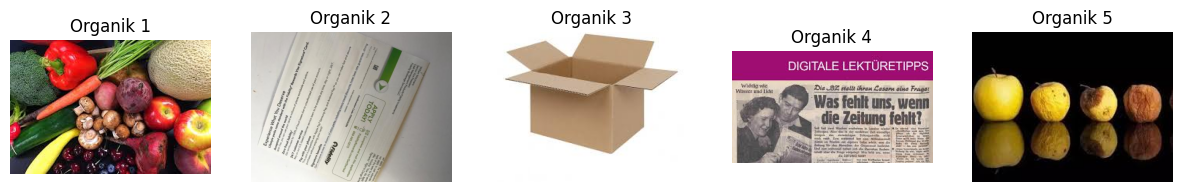

Kelas: Anorganik


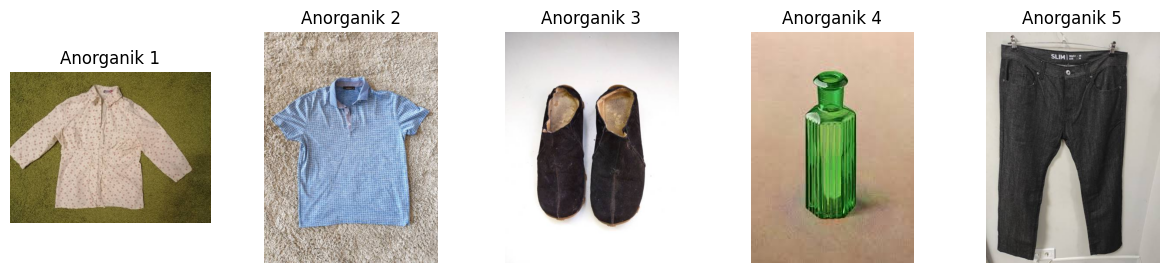

Kelas: B3


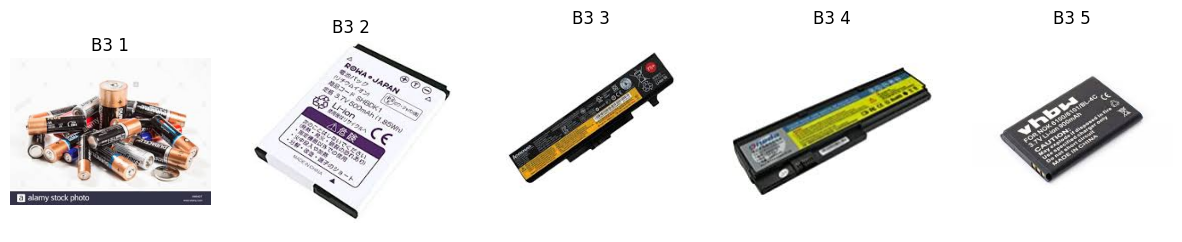

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Tentukan path direktori utama yang berisi folder per kelas
base_dir = "/content/drive/MyDrive/KS_seimbang3"
n_images_per_class = 5  # Tentukan berapa banyak gambar per kelas yang ingin ditampilkan

# Dapatkan daftar nama folder di dalam direktori utama (misalnya nama kelas)
class_folders = [f for f in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, f))]

# Loop untuk tiap kelas
for class_name in class_folders:
    class_path = os.path.join(base_dir, class_name)
    images = os.listdir(class_path)  # Daftar gambar di dalam folder kelas
    selected_images = images[:n_images_per_class]  # Pilih sejumlah gambar pertama

    print(f"Kelas: {class_name}")

    # Plot gambar-gambar dari kelas ini
    plt.figure(figsize=(15, 3))
    for i, img_name in enumerate(selected_images):
        img_path = os.path.join(class_path, img_name)
        img = Image.open(img_path)

        # Tampilkan gambar di subplot
        plt.subplot(1, n_images_per_class, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"{class_name} {i+1}")

    plt.show()

In [ ]:
import numpy as np
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Parameter
IMG_SIZE = (160, 160)
DATA_PATH = '/content/drive/MyDrive/KS_seimbang3'

# Urutkan nama kelas secara konsisten
class_names = sorted(os.listdir(DATA_PATH))
print("Class order:", class_names)

x = []
y = []

# Load gambar dan label
for i, class_name in enumerate(class_names):
    folder = os.path.join(DATA_PATH, class_name)
    if not os.path.isdir(folder):
        continue
    for fname in os.listdir(folder):
        path = os.path.join(folder, fname)
        try:
            img = load_img(path, target_size=IMG_SIZE)
            img = img_to_array(img) / 255.0
            x.append(img)
            y.append(i)
        except:
            continue  # skip file corrupt

x = np.array(x)
y = to_categorical(y)

print("Total data:", x.shape, y.shape)


Class order: ['Anorganik', 'B3', 'Organik']
Total data: (6000, 160, 160, 3) (6000, 3)


In [ ]:
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)
x_valid, x_test, y_valid, y_test = train_test_split(x_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print("Train:", x_train.shape)
print("Validation:", x_valid.shape)
print("Test:", x_test.shape)


Train: (4800, 160, 160, 3)
Validation: (600, 160, 160, 3)
Test: (600, 160, 160, 3)


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

input_tensor = Input(shape=(160, 160, 3))
base_model = MobileNetV2(include_top=False, weights='imagenet', input_tensor=input_tensor)
base_model.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
output = Dense(len(class_names), activation='softmax')(x)

model = Model(inputs=input_tensor, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Callbacks
checkpoint_path = "/content/drive/MyDrive/model_sampah3.keras"
callbacks = [
    EarlyStopping(patience=50, restore_best_weights=True, monitor='val_loss'),
    ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True)
]

# Training
history = model.fit(
    x_train, y_train,
    validation_data=(x_valid, y_valid),
    epochs=200,
    batch_size=32,
    callbacks=callbacks
)


<ipython-input-13-215240534>:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(include_top=False, weights='imagenet', input_tensor=input_tensor)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,340,163 (8.93 MB)

 Trainable params: 82,179 (321.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/200
150/150 ━━━━━━━━━━━━━━━━━━━━ 130s 812ms/step - accuracy: 0.7747 - loss: 0.5662 - val_accuracy: 0.9417 - val_loss: 0.1704
Epoch 2/200
150/150 ━━━━━━━━━━━━━━━━━━━━ 130s 866ms/step - accuracy: 0.9165 - loss: 0.2095 - val_accuracy: 0.9450 - val_loss: 0.1368
Epoch 3/200
150/150 ━━━━━━━━━━━━━━━━━━━━ 122s 811ms/step - accuracy: 0.9468 - loss: 0.1504 - val_accuracy: 0.9533 - val_loss: 0.1309
Epoch 4/200
150/150 ━━━━━━━━━━━━━━━━━━━━ 119s 796ms/step - accuracy: 0.9554 - loss: 0.1249 - val_accuracy: 0.9600 - val_loss: 0.1122
Epoch 5/200
150/150 ━━━━━━━━━━━━━━━━━━━━ 123s 822ms/step - accuracy: 0.9661 - loss: 0.1025 - val_accuracy: 0.9667 - val_loss: 0.1003
Epoch 6/200
150/150 ━━━━━━━━━━━━━━━━━━━━ 139s 805ms/step - accuracy: 0.9671 - loss: 0.0913 - val_accuracy: 0.9617 - val_loss: 0.1003
Epoch 7/200
150/150 ━━━━━━━━━━━━━━━━━━━━ 148s 846ms/step - accuracy: 0.9689 - loss: 0.0835 - val_accuracy: 0.9617 - val_loss: 0.1051
Epoch 8/200
150/150 ━━━━━━━━━━━━━━━━━━━━ 133s 789ms/step - accuracy: 

In [ ]:
# prompt: tampilkan berapa akurasinya train valid dan los dalam angka dan dalam persen

# Tampilkan hasil evaluasi pada dataset validasi
loss_valid, accuracy_valid = model.evaluate(x_valid, y_valid, verbose=0)

print(f"Akurasi Training: {history.history['accuracy'][-1]:.4f} ({history.history['accuracy'][-1]*100:.2f}%)")
print(f"Loss Training: {history.history['loss'][-1]:.4f}")
print(f"Akurasi Validasi: {accuracy_valid:.4f} ({accuracy_valid*100:.2f}%)")
print(f"Loss Validasi: {loss_valid:.4f}")

# Jika Anda ingin menampilkan akurasi dan loss pada dataset test setelah model terbaik dimuat (dari ModelCheckpoint)
# model.load_weights(checkpoint_path) # Muat bobot terbaik
# loss_test, accuracy_test = model.evaluate(x_test, y_test, verbose=0)
# print(f"Akurasi Test: {accuracy_test:.4f} ({accuracy_test*100:.2f}%)")
# print(f"Loss Test: {loss_test:.4f}")

Akurasi Training: 0.9967 (99.67%)
Loss Training: 0.0091
Akurasi Validasi: 0.9767 (97.67%)
Loss Validasi: 0.0720


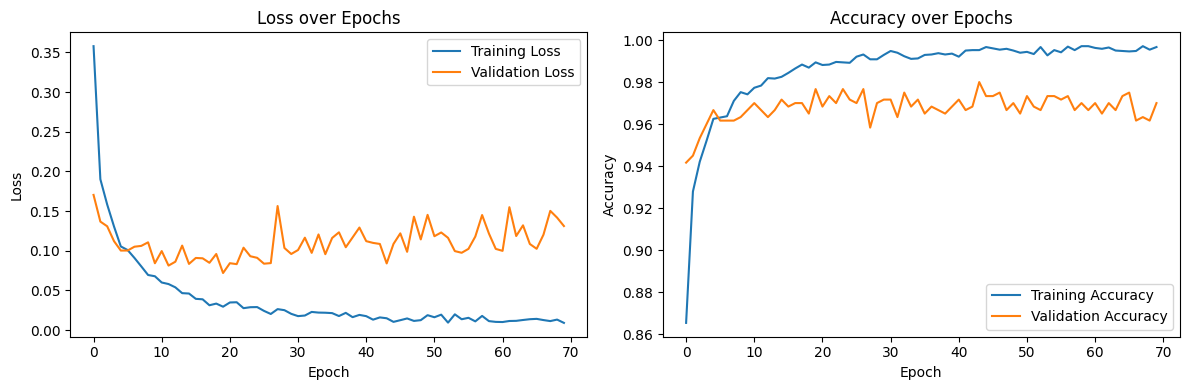

In [ ]:
# prompt: tampilkan grafiknya

import matplotlib.pyplot as plt
# Tampilkan grafik loss dan accuracy
plt.figure(figsize=(12, 4))

# Grafik Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Grafik Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# prompt: buatkan code untuk presisi f1 score recall

from sklearn.metrics import classification_report
from numpy import argmax

# Lakukan prediksi pada data uji
y_pred = model.predict(x_test)
y_pred_classes = argmax(y_pred, axis=1)
y_test_classes = argmax(y_test, axis=1)

# Dapatkan nama kelas dalam urutan yang sama seperti saat data dimuat
# Pastikan class_names diurutkan sama seperti saat data dimuat
# Jika Anda menggunakan `sorted(os.listdir(DATA_PATH))`, gunakan itu di sini
class_names = sorted(os.listdir(DATA_PATH)) # Pastikan ini sesuai dengan bagaimana Anda memuat data

# Tampilkan laporan klasifikasi
print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=class_names))


19/19 ━━━━━━━━━━━━━━━━━━━━ 17s 794ms/step

Classification Report:
              precision    recall  f1-score   support

   Anorganik       0.96      0.95      0.96       200
          B3       0.97      0.99      0.98       200
     Organik       0.95      0.94      0.95       200

    accuracy                           0.96       600
   macro avg       0.96      0.96      0.96       600
weighted avg       0.96      0.96      0.96       600



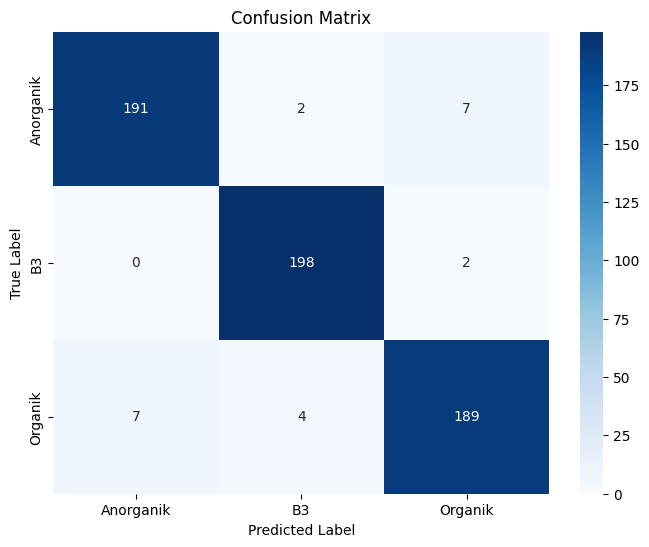

In [ ]:
# prompt: buatkan confusion matrix

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Hitung Confusion Matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

# Dapatkan nama kelas dalam urutan yang sama seperti saat data dimuat
# Pastikan class_names diurutkan sama seperti saat data dimuat
# Jika Anda menggunakan `sorted(os.listdir(DATA_PATH))`, gunakan itu di sini
class_names = sorted(os.listdir(DATA_PATH)) # Pastikan ini sesuai dengan bagaimana Anda memuat data

# Tampilkan Confusion Matrix menggunakan heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


**Prediksi**

In [2]:
from tensorflow.keras.models import load_model

# Load model terbaik yang disimpan oleh ModelCheckpoint
model = load_model("/content/drive/MyDrive/model_sampah3.keras")

ValueError: File not found: filepath=/content/drive/MyDrive/model_sampah3.keras. Please ensure the file is an accessible `.keras` zip file.

In [ ]:
n = 100 #nomor tes tes

plt.imshow(x_test[n])
plt.show()

true_label = np.argmax(y_test,axis=1)[n]
print("Gambar Yang Benar Adalah:",true_label,":",class_names[true_label])
prediction = model.predict(x_test[n][np.newaxis,...])[0]
print("prediksi Value:",prediction)
predicted_label = np.argmax(prediction)
print("prediksi gambar:",predicted_label,":",class_names[predicted_label])

if true_label == predicted_label:
    print("Prediksi Benar")
else:
    print("Prediksi Salah")

NameError: name 'plt' is not defined

**Ekspor Model ke Format TensorFlow Lite (.tflite)**

In [ ]:
from tensorflow.keras.models import load_model

# Load model terbaik yang disimpan oleh ModelCheckpoint
model = load_model("/content/drive/MyDrive/model_sampah3.keras")

import os

# Buat folder jika belum ada
os.makedirs('/content/drive/MyDrive/output model', exist_ok=True)


# Konversi model ke TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan .tflite
tflite_model_path = '/content/drive/MyDrive/output model/model_sampah3.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print("Model TFLite berhasil disimpan.")

Saved artifact at '/tmp/tmp7jac9w4g'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  137224649046928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137224649047696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137224649045584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137224649045200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137224649046736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137224649047120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137224649212560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137224649212944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137224649044624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137224649046160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137224649214096